The overall architecture is copied from the code in this Kaggle notebook.
https://www.kaggle.com/code/abiolatti/keras-baseline-seq2seq?scriptVersionId=180403717


The model architecture is based on the paper discussed in this Kaggle discussion and is detailed in this arXiv paper.

https://www.kaggle.com/competitions/leap-atmospheric-physics-ai-climsim/discussion/516605
https://arxiv.org/abs/2407.00124

I trained the model for 22 epochs. It achieved its highest performance at epoch 20 but showed signs of overfitting afterward.

In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import gc
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
 
from keras.regularizers import l2

import tensorflow as tf
import jax
import keras
from keras.layers import Conv1D, GroupNormalization, Activation
import keras_nlp

from sklearn import metrics

from tqdm.notebook import tqdm

print(tf.__version__)
print(jax.__version__)

2024-07-15 10:01:32.223329: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/root/miniconda3/envs/tf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.16.1
0.4.30


In [2]:
def is_interactive():
    return 'runtime' in get_ipython().config.IPKernelApp.connection_file

print('Interactive?', is_interactive())

Interactive? True


In [3]:
isTrain = True
SEED = 3407
keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [4]:
DATA = "autodl-tmp/kaggle/input"
DATA_TFREC = "autodl-tmp/archive"
model_path = "model.keras"

In [5]:
sample = pl.read_csv(os.path.join(DATA, "sample_submission.csv"), n_rows=1)
TARGETS = sample.select(pl.exclude('sample_id')).columns
print(len(TARGETS))

368


In [6]:
def _parse_function(example_proto):
    feature_description = {
        'x': tf.io.FixedLenFeature([556], tf.float32),
        'targets': tf.io.FixedLenFeature([368], tf.float32)
    }
    e = tf.io.parse_single_example(example_proto, feature_description)
    return e['x'], e['targets']

In [7]:
train_files = [os.path.join(DATA_TFREC, "train_%.3d.tfrec" % i) for i in range(100)]
valid_files = [os.path.join(DATA_TFREC, "train_%.3d.tfrec" % i) for i in range(100, 101)]

In [8]:
BATCH_SIZE = 512

train_options = tf.data.Options()
train_options.deterministic = True

ds_train = (
    tf.data.Dataset.from_tensor_slices(train_files)
    .with_options(train_options)
    .shuffle(100)
    .interleave(
        lambda file: tf.data.TFRecordDataset(file).map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE),
        num_parallel_calls=tf.data.AUTOTUNE,
        cycle_length=10,
        block_length=1000,
        deterministic=True
    )
    .shuffle(4 * BATCH_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

ds_valid = (
    tf.data.TFRecordDataset(valid_files)
    .map(_parse_function)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

2024-07-15 10:01:47.852221: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


2024-07-15 10:03:07.108483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


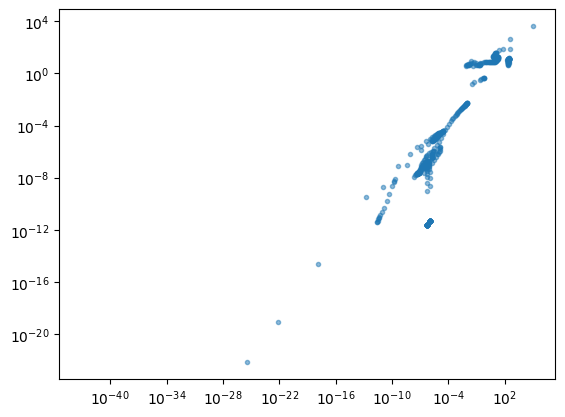

In [9]:
norm_x = keras.layers.Normalization()
norm_x.adapt(ds_train.map(lambda x, y: x))

plt.scatter(
    norm_x.mean.squeeze(),
    norm_x.variance.squeeze() ** 0.5,
    marker=".",
    alpha=0.5
)
plt.xscale('log')
plt.yscale('log')

2024-07-15 10:06:21.105344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


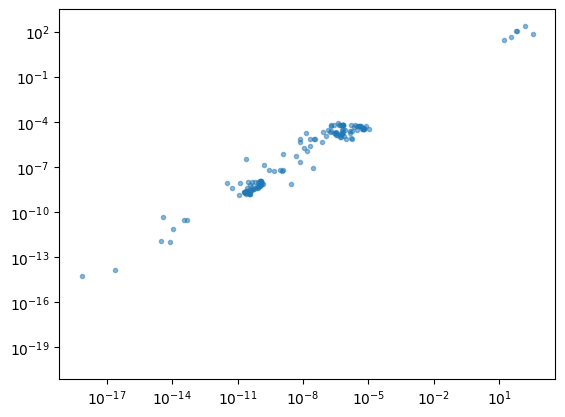

In [10]:
norm_y = keras.layers.Normalization()
norm_y.adapt(ds_train.map(lambda x, y: y))

mean_y = norm_y.mean
stdd_y = keras.ops.maximum(1e-20, norm_y.variance ** 0.5)

plt.scatter(
    mean_y.squeeze(),
    stdd_y.squeeze(),
    marker=".",
    alpha=0.5
)
plt.xscale('log')
plt.yscale('log')


In [11]:
min_y = np.min(np.stack([np.min(yb, 0) for _, yb in ds_train.take(20 if is_interactive() else 10000)], 0), 0, keepdims=True)
max_y = np.max(np.stack([np.max(yb, 0) for _, yb in ds_train.take(20 if is_interactive() else 10000)], 0), 0, keepdims=True)

2024-07-15 10:06:29.749682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-15 10:06:30.475199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Model definition & Training

In [12]:
epochs = 15 
    
learning_rate = 1e-3
early_patience = 5
# epochs_warmup = 1
# epochs_ending = 2
# steps_per_epoch = int(np.ceil(len(train_files) * 100_000 / BATCH_SIZE))

# lr_scheduler = keras.optimizers.schedules.CosineDecay(
#     1e-4, 
#     (epochs - epochs_warmup - epochs_ending) * steps_per_epoch, 
#     warmup_target=learning_rate,
#     warmup_steps=steps_per_epoch * epochs_warmup,
#     alpha=0.1
# )

# plt.plot([lr_scheduler(it) for it in range(0, epochs * steps_per_epoch, steps_per_epoch)]);

In [13]:
@keras.saving.register_keras_serializable(package="MyMetrics", name="ClippedR2Score")
class ClippedR2Score(keras.metrics.Metric):
    def __init__(self, name='r2_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.base_metric = keras.metrics.R2Score(class_aggregation=None)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.base_metric.update_state(y_true, y_pred, sample_weight=None)
        
    def result(self):
        return keras.ops.mean(keras.ops.clip(self.base_metric.result(), 0.0, 1.0))
        
    def reset_states(self):
        self.base_metric.reset_states()

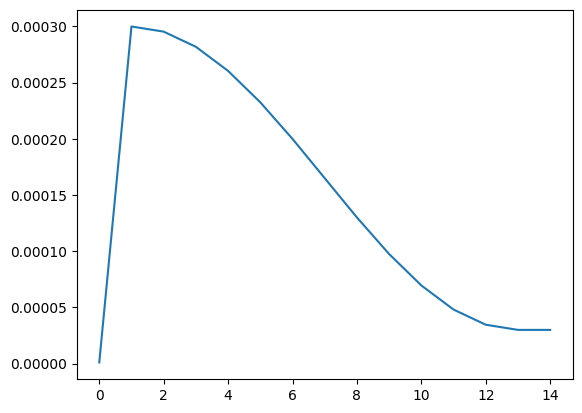

In [67]:
epochs = 15
learning_rate = 3e-4

epochs_warmup = 1
epochs_ending = 2
steps_per_epoch = int(np.ceil(len(train_files) * 100_000 / BATCH_SIZE))

lr_scheduler = keras.optimizers.schedules.CosineDecay(
    1e-6, 
    (epochs - epochs_warmup - epochs_ending) * steps_per_epoch, 
    warmup_target=learning_rate,
    warmup_steps=steps_per_epoch * epochs_warmup,
    alpha=0.1
)

plt.plot([lr_scheduler(it) for it in range(0, epochs * steps_per_epoch, steps_per_epoch)]);

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dense, Dropout

@keras.saving.register_keras_serializable()
class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, head_size, num_heads, ff_dim, dropout=0.1, **kwargs):
        super(TransformerEncoderLayer, self).__init__(**kwargs)
        self.att = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='gelu'),
            Dense(25)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output) 

In [16]:
# Transformer block
@keras.saving.register_keras_serializable()
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0.2):
    attention_output = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    attention_output = tf.keras.layers.Dropout(dropout)(attention_output)
    attention_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention_output + inputs)

    ff_output = tf.keras.layers.Dense(ff_dim, activation='gelu')(attention_output)
    ff_output = tf.keras.layers.Dropout(dropout)(ff_output)
    ff_output = tf.keras.layers.Dense(inputs.shape[-1])(ff_output)
    ff_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(ff_output + attention_output)

    return ff_output

# Transformer_CA block
@keras.saving.register_keras_serializable()
def transformer_CA_block(inputs, skip_features, head_size, num_heads, ff_dim, dropout=0.2):
    attention_output = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(skip_features, inputs)
    attention_output = tf.keras.layers.Dropout(dropout)(attention_output)
    attention_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention_output + skip_features)

    ff_output = tf.keras.layers.Dense(ff_dim, activation='gelu')(attention_output)
    ff_output = tf.keras.layers.Dropout(dropout)(ff_output)
    ff_output = tf.keras.layers.Dense(inputs.shape[-1])(ff_output)
    ff_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(ff_output + attention_output)

    return ff_output

# ResBlock function
@keras.saving.register_keras_serializable()
def res_block(x, filters, output_filters=None, groups=8):
    if output_filters is None:
        output_filters = filters
    norm1 = GroupNormalization(groups=groups, axis=-1)(x)
    silu1 = tf.keras.layers.Activation('swish')(norm1)
    conv1 = tf.keras.layers.Conv1D(filters, kernel_size=3, padding='same')(silu1)

    norm2 = GroupNormalization(groups=groups, axis=-1)(conv1)
    silu2 = tf.keras.layers.Activation('swish')(norm2)
    conv2 = tf.keras.layers.Conv1D(output_filters, kernel_size=3, padding='same')(silu2)

    if x.shape[-1] != conv2.shape[-1]:
        x = tf.keras.layers.Conv1D(output_filters, kernel_size=1, padding='same')(x)
    x = tf.keras.layers.Add()([conv2, x])
    norm3 = GroupNormalization(groups=groups, axis=-1)(x)
    return norm3

# Downsample block
@keras.saving.register_keras_serializable()
def repeat_block(x, filters, repeat):
    for _ in range(repeat):
        x = res_block(x, filters) 
    return x

# Upsample block
@keras.saving.register_keras_serializable()
def upsample_block(x, filters, repeat, concat_layer):
    num_heads = filters // 4
    concat_layer = transformer_CA_block(x, concat_layer, head_size=4, num_heads=num_heads, ff_dim=filters*2)
    x = tf.keras.layers.Conv1DTranspose(filters, kernel_size=2, strides=2, padding='same')(x)
    x = tf.keras.layers.Concatenate()([x, concat_layer])
    for _ in range(repeat):
        x = res_block(x, filters)
    return x

# Define a custom Lambda function to print and remove specific data slices
# TPU does not support printing in this manner, for compatibility, direct value retrieval is used instead.
# This function was previously used but later removed. Hence, there might be inconsistencies.
@keras.saving.register_keras_serializable()
def slice_and_print(x):
    # Print the first 2 time steps that are being removed
    tf.print("Removed start:", x[:, :2, :], summarize=-1)
    # Print the last 2 time steps that are being removed
    tf.print("Removed end:", x[:, -2:, :], summarize=-1)
    # Return the data after removing the padding from the start and end
    return x[:, 2:-2, :] 

In [73]:
%%time
# Path to the model file
model_filepath = 'model_epoch_01.keras'

# Check if the model file exists
if os.path.exists(model_filepath):
    print(f"Loading model from {model_filepath}")
    keras.utils.clear_session()
    custom_objects = {
        'R2Score': tf.keras.metrics.R2Score(class_aggregation="variance_weighted_average"),
    }
    model = keras.models.load_model(model_filepath, custom_objects)
else:
    print("Saved model not found, training a new model")

Loading model from model_epoch_01.keras
CPU times: user 4.39 s, sys: 1.29 s, total: 5.68 s
Wall time: 5.4 s


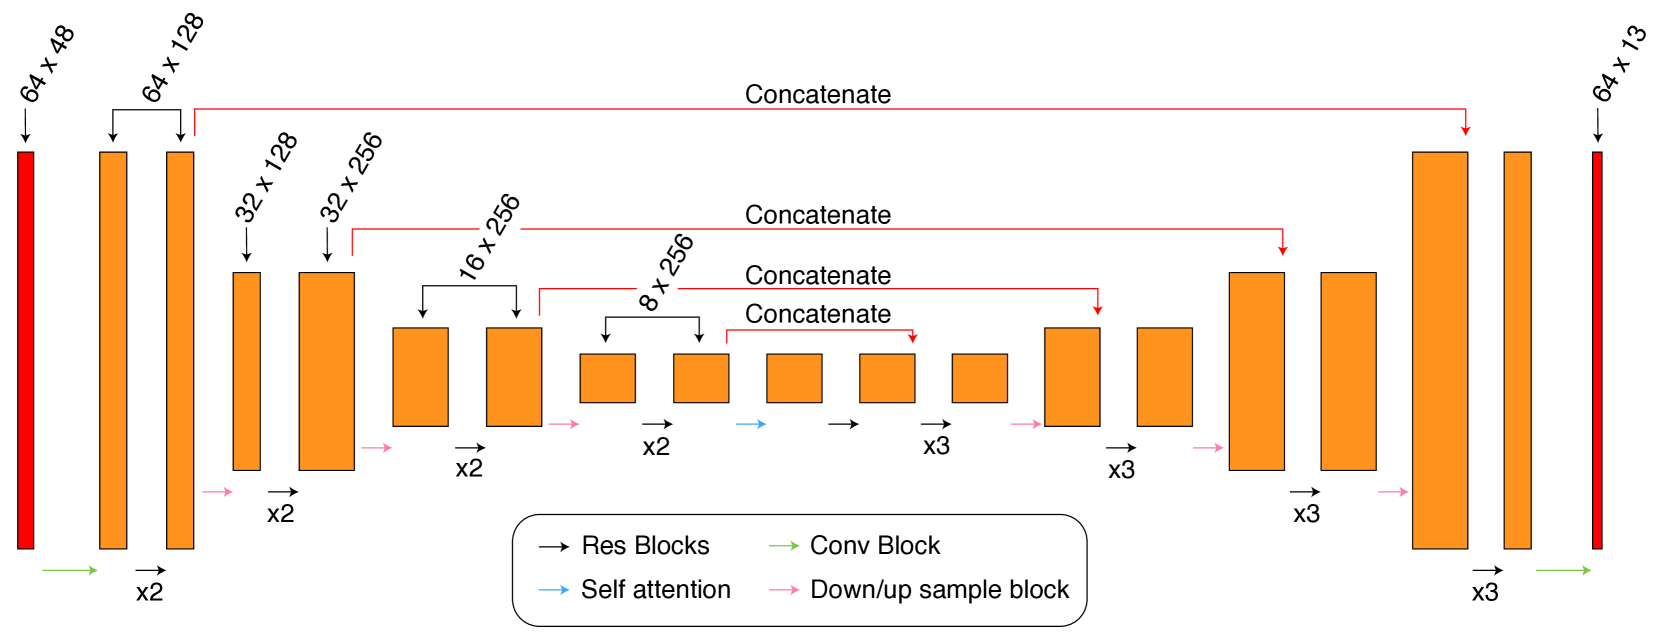

In [68]:
%%time

    # Clear the current Keras session
    keras.utils.clear_session() 

    def x_to_seq(x):
        x_seq0 = keras.ops.transpose(keras.ops.reshape(x[:, 0:60 * 6], (-1, 6, 60)), (0, 2, 1))
        x_seq1 = keras.ops.transpose(keras.ops.reshape(x[:, 60 * 6 + 16:60 * 9 + 16], (-1, 3, 60)), (0, 2, 1))
        x_flat = keras.ops.reshape(x[:, 60 * 6:60 * 6 + 16], (-1, 1, 16))
        x_flat = keras.ops.repeat(x_flat, 60, axis=1)
        return keras.ops.concatenate([x_seq0, x_seq1, x_flat], axis=-1) 
  
   
    # Build 1D U-Net model
    def create_unet(input_shape):
        inputs = keras.layers.Input(shape=input_shape)

        # Encoder
        encoder_1 = repeat_block(inputs, 128, 2)  # 64 x 128 x 2
        #encoder_1 = transformer_block(encoder_1, head_size=16, num_heads=8, ff_dim=256)
        encoder_1_down = keras.layers.MaxPooling1D(pool_size=2, strides=2)(encoder_1)  # Downsample # 32 x 128

        encoder_2 = repeat_block(encoder_1_down, 256, 2)  # 32 x 256 x 2
        #encoder_2 = transformer_block(encoder_2, head_size=32, num_heads=8, ff_dim=512)
        encoder_2_down = keras.layers.MaxPooling1D(pool_size=2, strides=2)(encoder_2)  # Downsample # 16 x 256

        encoder_3 = repeat_block(encoder_2_down, 256, 2)  # 16 x 256 x 2
        #encoder_3 = transformer_block(encoder_3, head_size=32, num_heads=8, ff_dim=512)
        encoder_3_down = keras.layers.MaxPooling1D(pool_size=2, strides=2)(encoder_3)  # Downsample # 8 x 256

        encoder_4 = repeat_block(encoder_3_down, 256, 2)  # 8 x 256 x 2

        # Bottleneck (Transformer)
        #bottle_neck_pe = keras_nlp.layers.SinePositionEncoding()(encoder_4)
        #bottle_neck = encoder_4 + bottle_neck_pe
        bottleneck = transformer_block(encoder_4, head_size=32, num_heads=8, ff_dim=512)
        bottleneck = repeat_block(bottleneck, 256, 1)  # 8 x 256 x 2
        
        #encoder_4 = transformer_CA_block(bottleneck, encoder_4, head_size=4, num_heads=64, ff_dim=512)
        decoder_1 = keras.layers.Concatenate()([bottleneck, encoder_4])
        decoder_1_block = repeat_block(decoder_1, 256, 3)  # 8 x 256 x 3
        #decoder_1_block = transformer_block(decoder_1_block, head_size=32, num_heads=8, ff_dim=512)
        decoder_1_upsample = keras.layers.Conv1DTranspose(256, kernel_size=2, strides=2, padding='same')(decoder_1_block)  # Upsample # 16 x 256
        
        #encoder_3 = transformer_CA_block(decoder_1_upsample, encoder_3, head_size=4, num_heads=64, ff_dim=512)
        decoder_2 = keras.layers.Concatenate()([decoder_1_upsample, encoder_3])
        decoder_2_block = repeat_block(decoder_2, 256, 3)  # 16 x 256 x 3
        #decoder_2_block = transformer_block(decoder_2_block, head_size=32, num_heads=8, ff_dim=512)
        decoder_2_upsample = keras.layers.Conv1DTranspose(256, kernel_size=2, strides=2, padding='same')(decoder_2_block)  # Upsample # 32 x 256
        
        #encoder_2 = transformer_CA_block(decoder_2_upsample, encoder_2, head_size=4, num_heads=64, ff_dim=512)
        decoder_3 = keras.layers.Concatenate()([decoder_2_upsample, encoder_2])
        decoder_3_block = repeat_block(decoder_3, 256, 3)  # 32 x 256 x 3
        #decoder_3_block = transformer_block(decoder_3_block, head_size=32, num_heads=8, ff_dim=512)
        decoder_3_upsample = keras.layers.Conv1DTranspose(256, kernel_size=2, strides=2, padding='same')(decoder_3_block)  # Upsample # 64 x 256

        decoder_4 = keras.layers.Concatenate()([decoder_3_upsample, encoder_1])
        decoder_4_block = repeat_block(decoder_4, 256, 3)  # 64 x 256 x 3

        model = keras.models.Model(inputs, decoder_4_block)
        return model
    
    X_input = x = keras.layers.Input(ds_train.element_spec[0].shape[1:]) 
    x = keras.layers.Normalization(mean=norm_x.mean, variance=norm_x.variance)(x)
    x = x_to_seq(x) 
  
    # Zero-padding at the beginning and end of the sequence to extend the length from 60 to 64
    x = keras.layers.ZeroPadding1D(padding=(2, 2))(x)
    # 
    e = keras.layers.Conv1D(48, 1, padding='same')(x)   
    e = create_unet(e.shape[1:])(e)      
      
    # Use a Lambda layer to remove the first and last 2 time steps 
    e = e[:, 2:-2, :]

    p_all = keras.layers.Conv1D(14, 1, padding='same')(e)
    print(p_all.shape)
    
    p_seq = p_all[:, :, :6]
    p_seq = keras.ops.transpose(p_seq, (0, 2, 1))
    p_seq = keras.layers.Flatten()(p_seq)
    assert p_seq.shape[-1] == 360

    p_flat = p_all[:, :, 6:6 + 8]
    p_flat = keras.ops.mean(p_flat, axis=1)
    assert p_flat.shape[-1] == 8

    P = keras.ops.concatenate([p_seq, p_flat], axis=1)

    # Build & compile the model
    model = keras.Model(X_input, P)
    model.compile(
        loss=keras.losses.Huber(delta=1.0), 
        optimizer=keras.optimizers.Adam(lr_scheduler),
        metrics=[keras.metrics.MeanSquaredError(), 
                     keras.metrics.R2Score(class_aggregation="variance_weighted_average"), 
        ]  # Updated R2Score
    )
    model.build(tuple(ds_train.element_spec[0].shape))
    model.summary()

(None, 60, 14)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 556)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 556)       │          0 │ input_layer[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 360)       │          0 │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180)       │          0 │ normalization[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 16)        │          0 │ normalization[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 6, 60)     │          0 │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 3, 60)     │          0 │ get_item_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 16)     │          0 │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose           │ (None, 60, 6)     │          0 │ reshape[0][0]     │
│ (Transpose)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_1         │ (None, 60, 3)     │          0 │ reshape_1[0][0]   │
│ (Transpose)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat (Repeat)     │ (None, 60, 16)    │          0 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 60, 25)    │          0 │ transpose[0][0],  │
│ (Concatenate)       │                   │            │ transpose_1[0][0… │
│                     │                   │            │ repeat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding1d      │ (None, 64, 25)    │          0 │ concatenate[0][0] │
│ (ZeroPadding1D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 64, 48)    │      1,248 │ zero_padding1d[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 64, 256)   │  9,722,080 │ conv1d[0][0]      │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 60, 256)   │          0 │ functional_1[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_49 (Conv1D)  │ (None, 60, 14)    │      3,598 │ get_item_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 60, 6)     │          0 │ conv1d_49[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_2         │ (None, 6, 60)     │          0 │ get_item_4[0][0]

 Total params: 9,726,926 (37.11 MB)

 Trainable params: 9,726,926 (37.11 MB)

 Non-trainable params: 0 (0.00 B)

CPU times: user 1.34 s, sys: 21.4 ms, total: 1.36 s
Wall time: 1.31 s


In [71]:
    # Build & compile the model
    model.compile(
        loss=keras.losses.Huber(delta=1.0), 
        optimizer=keras.optimizers.Adam(1e-6),
        metrics=[keras.metrics.MeanSquaredError(), 
                     keras.metrics.R2Score(class_aggregation="variance_weighted_average"), 
        ]  # Updated R2Score
    )
    model.build(tuple(ds_train.element_spec[0].shape))
    model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 556)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 556)       │          0 │ input_layer[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 360)       │          0 │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180)       │          0 │ normalization[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 16)        │          0 │ normalization[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 6, 60)     │          0 │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 3, 60)     │          0 │ get_item_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 16)     │          0 │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose           │ (None, 60, 6)     │          0 │ reshape[0][0]     │
│ (Transpose)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_1         │ (None, 60, 3)     │          0 │ reshape_1[0][0]   │
│ (Transpose)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat (Repeat)     │ (None, 60, 16)    │          0 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 60, 25)    │          0 │ transpose[0][0],  │
│ (Concatenate)       │                   │            │ transpose_1[0][0… │
│                     │                   │            │ repeat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding1d      │ (None, 64, 25)    │          0 │ concatenate[0][0] │
│ (ZeroPadding1D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 64, 48)    │      1,248 │ zero_padding1d[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 64, 256)   │  9,722,080 │ conv1d[0][0]      │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 60, 256)   │          0 │ functional_1[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_49 (Conv1D)  │ (None, 60, 14)    │      3,598 │ get_item_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 60, 6)     │          0 │ conv1d_49[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_2         │ (None, 6, 60)     │          0 │ get_item_4[0][0]

 Total params: 9,726,926 (37.11 MB)

 Trainable params: 9,726,926 (37.11 MB)

 Non-trainable params: 0 (0.00 B)

In [72]:
%%time

# Normalize target values for training and validation datasets
ds_train_target_normalized = ds_train.map(lambda x, y: (x, (y - mean_y) / stdd_y))
ds_valid_target_normalized = ds_valid.map(lambda x, y: (x, (y - mean_y) / stdd_y))

if isTrain:
    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 

    # Model checkpoint callback
    model_checkpoint = ModelCheckpoint(
        filepath='model_epoch_{epoch:02d}.keras',  # Save model with epoch number
        monitor='val_loss',  # Monitor validation loss
        save_best_only=False,  # Save all models, not just the best one
        save_weights_only=False,  # Save the entire model structure and weights
        mode='min',  # 'min' indicates saving when the monitored value decreases
        verbose=2  # Provide detailed logging
    )

    # Early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitor validation loss
        patience=early_patience,  # Number of epochs to wait before stopping
        restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
    )

    # Train the model
    history = model.fit(
        ds_train_target_normalized,  # Training data
        validation_data=ds_valid_target_normalized,  # Validation data
        epochs=epochs,  # Number of epochs to train
        verbose=1 if is_interactive() else 2,  # Verbose output
        callbacks=[early_stopping, model_checkpoint]  # List of callbacks to apply during training
    )


Cause: could not parse the source code of <function <lambda> at 0x7f28587de7a0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f28587de7a0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f29d06440e0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f29d06440e0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/15
  19531/Unknown 699s 35ms/step - loss: 0.0633 - mean_squared_error: 0.2252 - r2_score: 0.7163

2024-07-16 00:58:23.708609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  19532/Unknown 718s 36ms/step - loss: 0.0633 - mean_squared_error: 0.2252 - r2_score: 0.7163

2024-07-16 00:58:49.924388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 1: saving model to model_epoch_01.keras
19532/19532 ━━━━━━━━━━━━━━━━━━━━ 728s 36ms/step - loss: 0.0633 - mean_squared_error: 0.2252 - r2_score: 0.7163 - val_loss: 0.0612 - val_mean_squared_error: 0.2119 - val_r2_score: 0.7104
Epoch 2/15
   77/19532 ━━━━━━━━━━━━━━━━━━━━ 10:37 33ms/step - loss: 0.0603 - mean_squared_error: 0.1914 - r2_score: 0.7368

Exception ignored in: <function _xla_gc_callback at 0x7f2dbfa1dda0>
Traceback (most recent call last):
  File "/root/miniconda3/envs/tf/lib/python3.11/site-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


   87/19532 ━━━━━━━━━━━━━━━━━━━━ 10:36 33ms/step - loss: 0.0604 - mean_squared_error: 0.1921 - r2_score: 0.7369

Exception ignored in: <function _xla_gc_callback at 0x7f2dbfa1dda0>
Traceback (most recent call last):
  File "/root/miniconda3/envs/tf/lib/python3.11/site-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


  109/19532 ━━━━━━━━━━━━━━━━━━━━ 10:36 33ms/step - loss: 0.0606 - mean_squared_error: 0.1926 - r2_score: 0.7371

KeyboardInterrupt: 

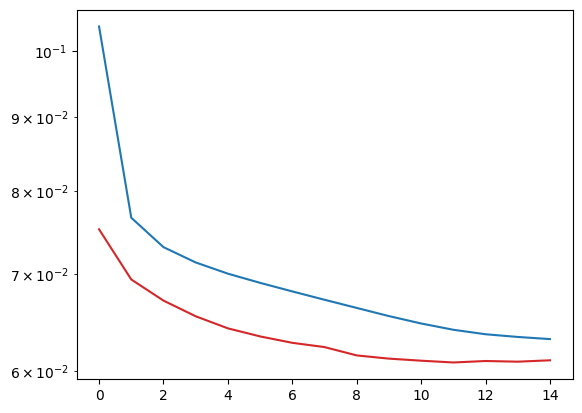

In [39]:
if isTrain:
    plt.plot(history.history['loss'], color='tab:blue')
    plt.plot(history.history['val_loss'], color='tab:red')
    plt.yscale('log');

In [74]:
y_valid = np.concatenate([yb for _, yb in ds_valid])
p_valid = model.predict(ds_valid, batch_size=BATCH_SIZE) * stdd_y + mean_y

2024-07-16 00:59:33.748919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


    175/Unknown 7s 21ms/step

2024-07-16 00:59:40.743327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


179/179 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step


[ 9.89631951e-01  9.96568084e-01  9.98523593e-01  9.99173820e-01
  9.99366701e-01  9.99490499e-01  9.99488890e-01  9.99385834e-01
  9.99198437e-01  9.98960555e-01  9.98638988e-01  9.98307586e-01
  9.97973919e-01  9.97585475e-01  9.97024477e-01  9.95710611e-01
  9.76250470e-01  7.74313927e-01  6.27350450e-01  5.85993946e-01
  6.33645535e-01  6.92188978e-01  7.02540398e-01  7.38424063e-01
  7.78454423e-01  8.07247043e-01  8.44008982e-01  8.80223215e-01
  8.97580326e-01  9.10086036e-01  9.18604851e-01  9.20523643e-01
  9.17066574e-01  9.06780601e-01  8.91548634e-01  8.72441828e-01
  8.49279881e-01  8.21467578e-01  7.95819283e-01  7.59953022e-01
  7.21958518e-01  6.87346697e-01  6.60332382e-01  6.35298967e-01
  6.23137176e-01  5.99296808e-01  5.70867479e-01  5.45919478e-01
  5.32372594e-01  5.25080800e-01  5.12706161e-01  5.10571837e-01
  5.09836495e-01  5.19596577e-01  5.31662226e-01  5.55640221e-01
  5.79680324e-01  5.92866778e-01  6.36636317e-01  8.06331217e-01
 -8.43988061e-01 -1.08617

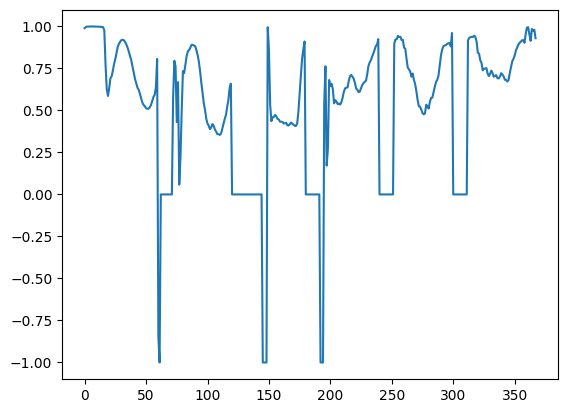

In [75]:
scores_valid = np.array([metrics.r2_score(y_valid[:, i], p_valid[:, i]) for i in range(len(TARGETS))])
print(scores_valid)
plt.plot(scores_valid.clip(-1, 1))

In [76]:
mask = scores_valid <= 1e-3
f"Number of under-performing targets: {sum(mask)}"

'Number of under-performing targets: 80'

In [77]:
f"Clipped score: {scores_valid.clip(0, 1).mean()}"

'Clipped score: 0.5500237005560294'

In [22]:
del y_valid, p_valid
gc.collect();

# Submission

In [23]:
sample = pl.read_csv("/kaggle/input/leap-atmospheric-physics-ai-climsim/sample_submission.csv")

In [24]:
df_test = (
    pl.scan_csv("/kaggle/input/leap-atmospheric-physics-ai-climsim/test.csv")
    .select(pl.exclude("sample_id"))
    .cast(pl.Float32)
    .collect()
)

In [25]:
gc.collect();

In [26]:
%%time
p_test = model.predict(df_test.to_numpy(), batch_size=4 * BATCH_SIZE) * stdd_y + mean_y
p_test = np.array(p_test)
p_test[:, mask] = mean_y[:, mask]

Removed start: Traced<ShapedArray(float32[2048,2,256])>with<DynamicJaxprTrace(level=1/0)>
Removed end: Traced<ShapedArray(float32[2048,2,256])>with<DynamicJaxprTrace(level=1/0)>


2024-07-08 02:22:10.472397: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[2048,256,64]{2,1,0}, u8[0]{0}) custom-call(f32[2048,256,32]{2,1,0}, f32[256,256,2]{2,1,0}), window={size=2 stride=2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convBackwardInput", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-08 02:22:10.478198: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.005972094s
Trying algorithm eng0{} for conv (f32[2048,256,64]{2,1,0}, u8[0]{0}) custom-call(f32[2048,256,32]{2,1,0}, f32[256,256,2]{2,1,0}), window={size=2 stride=2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convBackwardInput", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...


305/306 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/stepRemoved start: Traced<ShapedArray(float32[360,2,256])>with<DynamicJaxprTrace(level=1/0)>
Removed end: Traced<ShapedArray(float32[360,2,256])>with<DynamicJaxprTrace(level=1/0)>
306/306 ━━━━━━━━━━━━━━━━━━━━ 61s 169ms/step
CPU times: user 44.3 s, sys: 26.9 s, total: 1min 11s
Wall time: 1min 8s


In [27]:
# correction of ptend_q0002 targets (from 12 to 29)
df_p_test = pd.DataFrame(p_test, columns=TARGETS)

for idx in range(12, 30):
    df_p_test[f"ptend_q0002_{idx}"] = -df_test[f"state_q0002_{idx}"].to_numpy() / 1200
    
p_test = df_p_test.values

In [28]:
submission = sample.to_pandas()
submission[TARGETS] = submission[TARGETS] * p_test
pl.from_pandas(submission[["sample_id"] + TARGETS]).write_csv("submission.csv")

Potential Optimizations and Improvements to Consider:
1、Fine-tune Learning Rate: Experiment with lowering the learning rate and continuing training for more epochs to potentially enhance model performance.

2、Model Fusion: Integrate optimal results from open-source notebooks or other personal models to improve overall model performance through ensemble techniques.

3、Explore Alternative Models: Investigate alternative models to explore potentially better results and identify models that may better fit the problem domain.

4、Data Preprocessing and Post-processing: Optimize data preprocessing techniques and explore advanced post-processing methods to refine model outputs and improve accuracy.

Wishing everyone the best of luck!